In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy

from models import JacobianCI

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = False
dpi=150

In [4]:
def train_model(model, train_len=1000, nsamples_space=2**8):
    # Train model
    loss_history = []
    for epoch in tqdm.trange(train_len):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        loss_history.append(loss)
    loss_history = np.array(loss_history)
    return loss_history

In [5]:
# load trained model
dtype = torch.float32
# choose seed such that metagon is contained in zero-centered unit cell
model = JacobianCI(ncells=100,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
loss_history = train_model(model)

100%|██████████| 1000/1000 [00:01<00:00, 535.69it/s]


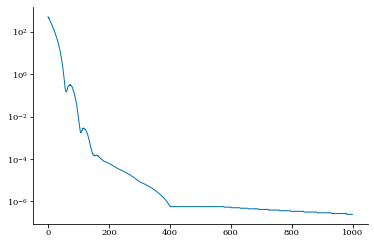

In [6]:
plt.semilogy(loss_history)

In [7]:
res = 32
start, end = -2,2
mesh = np.meshgrid(np.linspace(start,end,res),np.linspace(start,end,res))
rs = np.stack([mesh[0].flatten(),mesh[1].flatten()],axis=1)
activity = model(torch.tensor(rs,dtype=dtype)).detach().numpy()
random_model = JacobianCI(ncells=100,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=None)
random_activity = random_model(torch.tensor(rs,dtype=dtype)).detach().numpy()
rs.shape, activity.shape

((1024, 2), (1024, 100))

In [27]:
subselect = None
ratemaps = scipy.stats.binned_statistic_2d(rs[:,0],rs[:,1],activity.T,bins=res,statistic="mean").statistic
random_ratemaps = scipy.stats.binned_statistic_2d(rs[:,0],rs[:,1],random_activity.T,bins=res,statistic="mean").statistic
if subselect is not None:
    ratemaps = np.random.permutation(ratemaps)[:subselect]
#random_ratemaps = scipy.stats.binned_statistic_2d(rs[:,0],rs[:,1],random_activity.T,bins=res,statistic="mean").statistic[:subselect]
def random_shift_ratemaps(ratemaps):
    # ratemaps shape: (n_cells, res, res)
    shift = ratemaps.shape[1] - 1
    ratemaps = np.array([np.roll(ratemaps[i], np.random.randint(0, shift), axis=1) for i in range(ratemaps.shape[0])])
    ratemaps = np.array([np.roll(ratemaps[i], np.random.randint(0, shift), axis=0) for i in range(ratemaps.shape[0])])
    return ratemaps
#random_ratemaps = random_shift_ratemaps(ratemaps)
ratemaps.shape

(100, 32, 32)

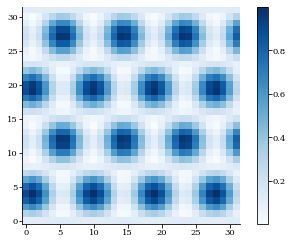

In [28]:
plt.imshow(ratemaps[1],origin="lower")
plt.colorbar()

1.1534782737510678e-12 0.14411783568180042 71.13248118755102 0.0019552102589400593


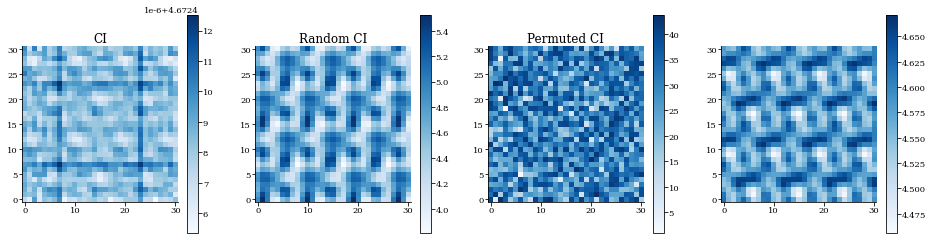

In [29]:
ci = np.sum(np.diff(ratemaps, axis=1)[:,:,:-1]**2 + np.diff(ratemaps, axis=2)[:,:-1]**2, axis=0)
random_ci = np.sum(np.diff(random_ratemaps, axis=1)[:,:,:-1]**2 + np.diff(random_ratemaps, axis=2)[:,:-1]**2, axis=0)
perm_ratemaps = np.random.permutation(ratemaps.reshape(-1,res**2).T).T.reshape(-1,res,res)
perm_ci = np.sum(np.diff(perm_ratemaps, axis=1)[:,:,:-1]**2 + np.diff(perm_ratemaps, axis=2)[:,:-1]**2, axis=0)
subselect = 98
subselect_ci = np.sum(np.diff(ratemaps[:subselect], axis=1)[:,:,:-1]**2 + np.diff(ratemaps[:subselect], axis=2)[:,:-1]**2, axis=0)
print(np.var(ci), np.var(random_ci), np.var(perm_ci), np.var(subselect_ci))
fig, axs = plt.subplots(ncols=4,figsize=(4*4,4))
im = axs[0].imshow(ci,origin="lower")
plt.colorbar(im,ax=axs[0])
axs[0].set_title("CI")
im = axs[1].imshow(random_ci,origin="lower")
plt.colorbar(im,ax=axs[1])
axs[1].set_title("Random CI")
im = axs[2].imshow(perm_ci,origin="lower")
plt.colorbar(im,ax=axs[2])
axs[2].set_title("Permuted CI")
im = axs[3].imshow(subselect_ci,origin="lower")
plt.colorbar(im,ax=axs[3])

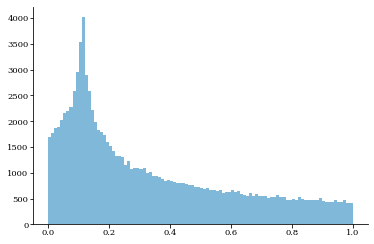

In [11]:
plt.hist(activity.flatten(),bins=100,alpha=0.5);

1.3541848510866908e-15 0.000525991973968644 0.0009095923593194274 0.0018014523355757085


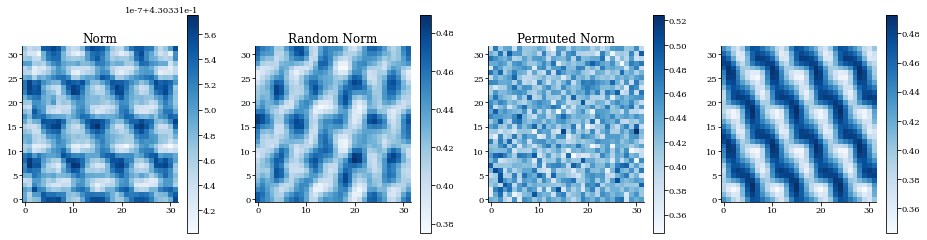

In [12]:
fig, axs = plt.subplots(ncols=4,figsize=(4*4,4))
ncells = ratemaps.shape[0]
norm_rate = np.linalg.norm(ratemaps,axis=0) / np.sqrt(ncells)
norm_random_rate = np.linalg.norm(random_ratemaps,axis=0) / np.sqrt(ncells)
norm_perm_rate = np.linalg.norm(np.random.permutation(ratemaps.flatten()).reshape(ratemaps.shape),axis=0) / np.sqrt(ncells)
norm_subselect_rate = np.linalg.norm(ratemaps[np.random.randint(0,ncells,ncells//2)],axis=0) / np.sqrt(ncells//2)
#norm_rate = np.diff(norm_rate, axis=0)[:,:-1]**2 + np.diff(norm_rate, axis=1)[:-1]**2
#norm_random_rate = np.diff(norm_random_rate, axis=0)[:,:-1]**2 + np.diff(norm_random_rate, axis=1)[:-1]**2
#norm_perm_rate = np.diff(norm_perm_rate, axis=0)[:,:-1]**2 + np.diff(norm_perm_rate, axis=1)[:-1]**2
#norm_subselect_rate = np.diff(norm_subselect_rate, axis=0)[:,:-1]**2 + np.diff(norm_subselect_rate, axis=1)[:-1]**2
print(np.var(norm_rate), np.var(norm_random_rate), np.var(norm_perm_rate), np.var(norm_subselect_rate))
im = axs[0].imshow(norm_rate,origin="lower")
plt.colorbar(im,ax=axs[0])
axs[0].set_title("Norm")
im = axs[1].imshow(norm_random_rate,origin="lower")
plt.colorbar(im,ax=axs[1])
axs[1].set_title("Random Norm")
im = axs[2].imshow(norm_perm_rate,origin="lower")
plt.colorbar(im,ax=axs[2])
axs[2].set_title("Permuted Norm")
im = axs[3].imshow(norm_subselect_rate,origin="lower")
plt.colorbar(im,ax=axs[3])

In [13]:
perturbed_ci.shape

NameError: name 'perturbed_ci' is not defined

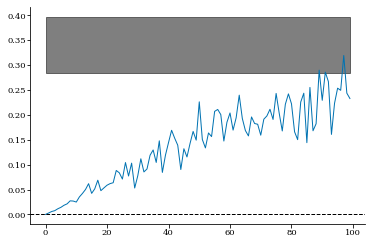

In [ ]:
# perturb phases and compute CI
import copy
perturbed_ci = []
random_ci = []
nevals=100
for i in range(nevals):
    perturbed_phases = model.unit_cell.wrap(model.phases.detach().numpy() + np.random.randn(model.ncells,2)*0.001*i)
    perturbed_model = copy.deepcopy(model)
    perturbed_model.set_phases(perturbed_phases)
    perturbed_activity = perturbed_model(torch.tensor(rs,dtype=dtype)).detach().numpy()
    perturbed_ratemap = scipy.stats.binned_statistic_2d(rs[:,0],rs[:,1],perturbed_activity.T,bins=res,statistic="mean").statistic
    perturbed_ci.append(np.sum(np.diff(perturbed_ratemap, axis=1)[:,:,:-1]**2 + np.diff(perturbed_ratemap, axis=2)[:,:-1]**2, axis=0).std())
    # random model
    random_model = copy.deepcopy(model)
    random_model.set_phases(model.unit_cell.sample(model.ncells))
    random_activity = random_model(torch.tensor(rs,dtype=dtype)).detach().numpy()
    random_ratemap = scipy.stats.binned_statistic_2d(rs[:,0],rs[:,1],random_activity.T,bins=res,statistic="mean").statistic
    random_ci.append(np.sum(np.diff(random_ratemap, axis=1)[:,:,:-1]**2 + np.diff(random_ratemap, axis=2)[:,:-1]**2, axis=0).std())
perturbed_ci = np.array(perturbed_ci)
random_ci = np.array(random_ci)

plt.plot(perturbed_ci)
plt.axhline(ci.std(),color="k",ls="--")
x = np.arange(nevals)  # create an array of x-values
plt.fill_between(x, np.ones(nevals)*(random_ci.mean()-random_ci.std()), np.ones(nevals)*(random_ci.mean()+random_ci.std()), color="k", alpha=0.5)

In [ ]:
x = np.arange(nevals)  # create an array of x-values
plt.fill_between(x, np.ones(nevals)*(random_ci.mean()-random_ci.std()), np.ones(nevals)*(random_ci.mean()+random_ci.std()), color="k", alpha=0.5)

In [ ]:
def ratemaps_ci(rs, activity):
    ratemaps = scipy.stats.binned_statistic_2d(rs[:,0],rs[:,1],activity.T,bins=res,statistic="mean").statistic
    ci = np.sum(np.diff(ratemaps, axis=1)[:,:,:-1]**2 + np.diff(ratemaps, axis=2)[:,:-1]**2, axis=0)
    return np.var(ci)

In [ ]:
cis = []
random_cis = []
perturbed_cis = []
ncells_range = np.arange(7, 500, 40)
for ncells in tqdm.tqdm(ncells_range):
    model = JacobianCI(ncells=ncells,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
    # random model
    #random_activity = model(torch.tensor(rs,dtype=dtype)).detach().numpy()
    #random_ci = ratemaps_ci(rs, random_activity)
    random_ci = model.loss_fn(torch.tensor(rs,dtype=dtype)).item()
    random_cis.append(random_ci)
    # optimal (CI) model
    loss_history = train_model(model)
    #activity = model(torch.tensor(rs,dtype=dtype)).detach().numpy()
    #ci = ratemaps_ci(rs, activity)
    ci = model.loss_fn(torch.tensor(rs,dtype=dtype)).item()
    cis.append(ci)
    # perturb phases and compute CI
    perturbed_ci = []
    nevals=100
    for i in range(nevals):
        # perturbation is uniform in angle space with constant magnitude
        perturbation = np.random.randn(model.ncells,2)
        perturbation = 0.001*i * perturbation #/ np.linalg.norm(perturbation, axis=1)[:,None]
        #perturbed_phases = model.unit_cell.wrap(model.phases.detach().numpy() + perturbation)
        perturbed_phases = model.unit_cell.wrap(perturbation)
        perturbed_model = copy.deepcopy(model)
        perturbed_model.set_phases(perturbed_phases)
        #perturbed_activity = perturbed_model(torch.tensor(rs,dtype=dtype)).detach().numpy()
        #perturbed_ci.append(ratemaps_ci(rs, perturbed_activity))
        perturbed_ci.append(perturbed_model.loss_fn(torch.tensor(rs,dtype=dtype)).item())
    perturbed_cis.append(np.array(perturbed_ci))
cis = np.array(cis)
random_cis = np.array(random_cis)
perturbed_cis = np.array(perturbed_cis)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:55<00:00,  4.30s/it]


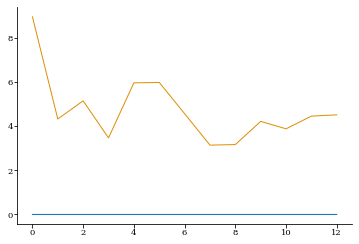

In [ ]:
plt.plot(cis)
plt.plot(random_cis/ncells_range)

Text(0, 0.5, 'pertubation magnitude')

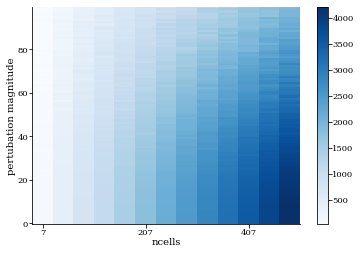

In [ ]:
plt.imshow(perturbed_cis.T/ncells_range,aspect="auto", origin="lower")
plt.xticks(np.arange(0,len(ncells_range),5),ncells_range[::5])
plt.colorbar()
plt.xlabel("ncells")
plt.ylabel("pertubation magnitude")

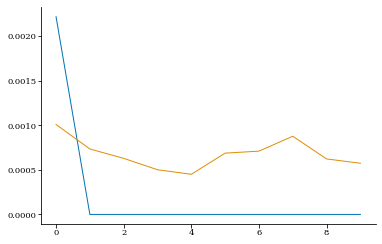

In [ ]:
plt.plot(cis)
plt.plot(random_cis/ncells_range)

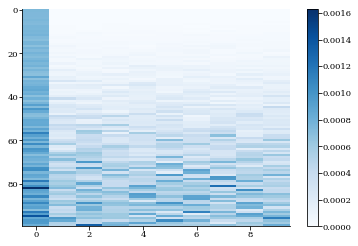

In [ ]:
plt.imshow(perturbed_cis.T/ncells_range,aspect="auto")
plt.colorbar()